In [2]:
import pandas as pd
import numpy as np
import os

np.random.seed(42)

# Define FreshRoute's warehouse locations
warehouses = ['Edinburgh', 'Manchester', 'Birmingham', 'Bristol', 'Leeds', 'London']

# Simulate 300 delivery records
n = 300
data = {
    'Warehouse': np.random.choice(warehouses, size=n),
    'Product_Category': np.random.choice(['Fruit', 'Vegetables', 'Dairy', 'Meat'], size=n),
    'Delivery_Delay_Days': np.random.exponential(scale=1.5, size=n).round(1),
}

# Simulate spoilage with regional performance bias
spoilage = []
for i in range(n):
    delay = data['Delivery_Delay_Days'][i]
    location = data['Warehouse'][i]
    base_risk = delay * 8 + np.random.normal(0, 3)
    
    # Adjust risk by warehouse performance
    if location == 'Edinburgh':
        base_risk *= 0.6
    elif location == 'London':
        base_risk *= 0.8
    elif location in ['Birmingham', 'Bristol']:
        base_risk *= 1.2
    spoilage.append(min(max(round(base_risk, 1), 0), 100))

data['Spoilage_Percentage'] = spoilage

df = pd.DataFrame(data)
print(df.head())

# Save to Desktop
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
file_path = os.path.join(desktop_path, "simulated_delivery_data.csv")
df.to_csv(file_path, index=False)
print("File saved to:", file_path)


    Warehouse Product_Category  Delivery_Delay_Days  Spoilage_Percentage
0     Bristol             Meat                  4.3                 35.8
1       Leeds       Vegetables                  3.0                 20.6
2  Birmingham            Fruit                  1.5                 15.2
3       Leeds            Dairy                  2.4                 21.7
4       Leeds            Fruit                  1.7                 13.6
File saved to: /Users/jeannsengiyumva/Desktop/simulated_delivery_data.csv


In [ ]:
#Visual Highlights

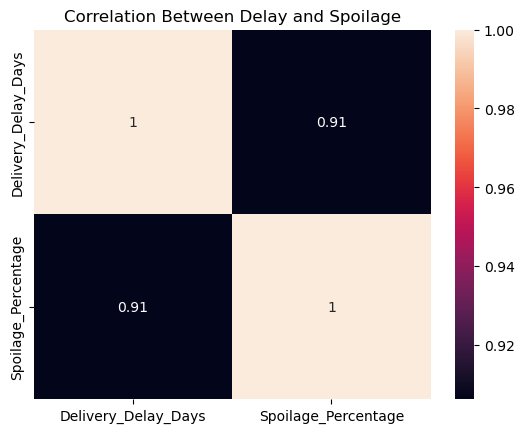

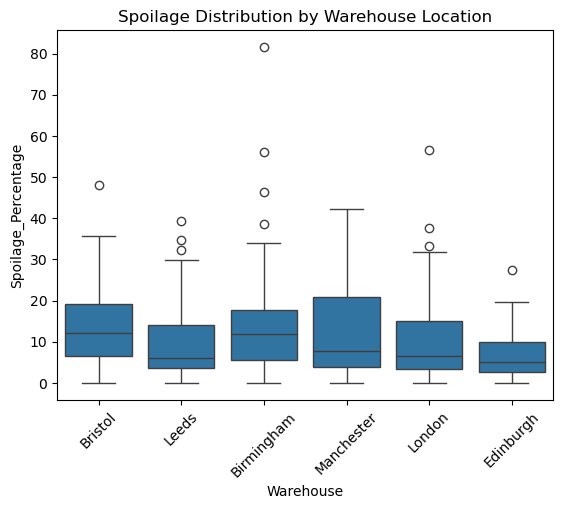

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
sns.heatmap(df[['Delivery_Delay_Days', 'Spoilage_Percentage']].corr(), annot=True)
plt.title("Correlation Between Delay and Spoilage")
plt.show()

# Boxplot to show the Spoilage by warehouse
sns.boxplot(x='Warehouse', y='Spoilage_Percentage', data=df)
plt.title("Spoilage Distribution by Warehouse Location")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Python Code: Spoilage Risk Classifier with Visuals

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        89
           1       0.00      0.00      0.00         1

    accuracy                           0.98        90
   macro avg       0.49      0.49      0.49        90
weighted avg       0.98      0.98      0.98        90

ROC AUC Score: 0.9775280898876404


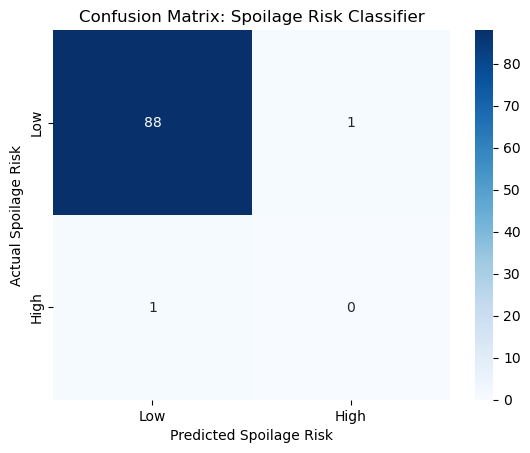

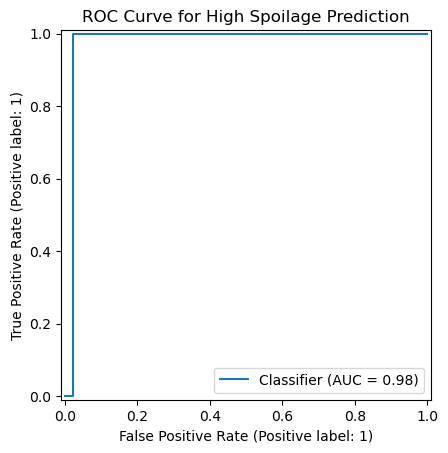

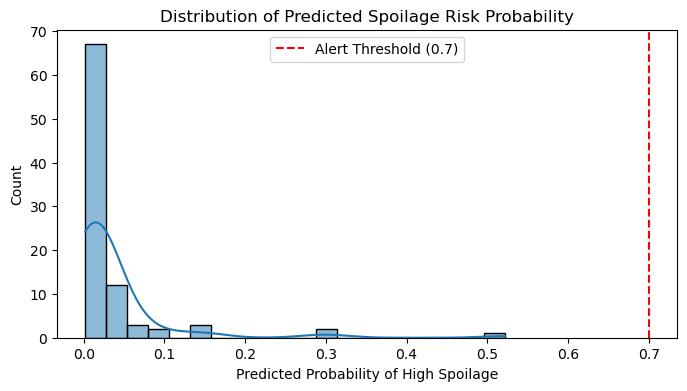

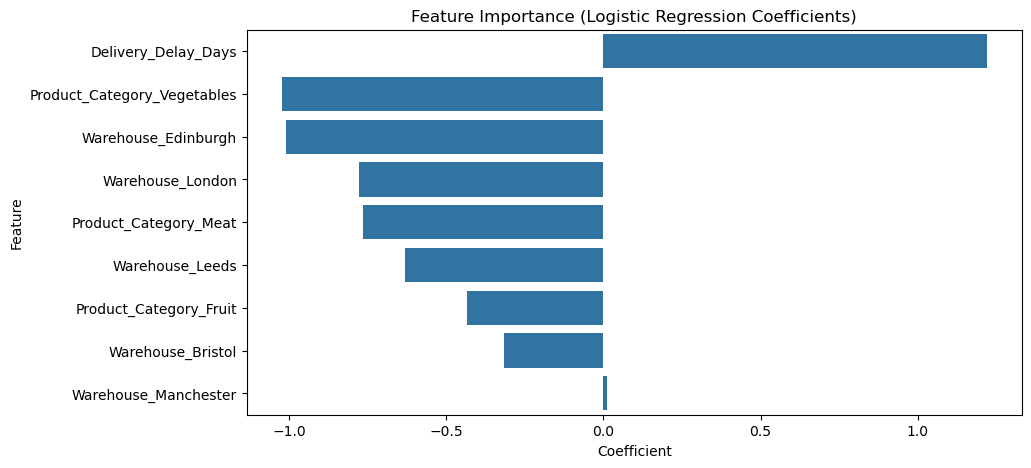

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Simulated data from previous step (assumes df exists)
df = df.copy()

# Create a binary target: 1 if spoilage > 40%
df['High_Spoilage'] = (df['Spoilage_Percentage'] > 40).astype(int)

# Define feature columns
categorical_features = ['Warehouse', 'Product_Category']
numerical_features = ['Delivery_Delay_Days']

# Train/test split
X = df[categorical_features + numerical_features]
y = df['High_Spoilage']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Preprocessing: OneHot + Scaling
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features),
    ('num', StandardScaler(), numerical_features)
])

# Logistic Regression pipeline
model = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Low", "High"], yticklabels=["Low", "High"])
plt.xlabel("Predicted Spoilage Risk")
plt.ylabel("Actual Spoilage Risk")
plt.title("Confusion Matrix: Spoilage Risk Classifier")
plt.show()

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve for High Spoilage Prediction")
plt.show()

# Probability Distribution Plot
plt.figure(figsize=(8, 4))
sns.histplot(y_prob, bins=20, kde=True)
plt.axvline(0.7, color='red', linestyle='--', label='Alert Threshold (0.7)')
plt.title("Distribution of Predicted Spoilage Risk Probability")
plt.xlabel("Predicted Probability of High Spoilage")
plt.legend()
plt.show()

# Feature importance (if using Logistic Regression)
model_coef = model.named_steps['classifier'].coef_[0]
feature_names = model.named_steps['preprocessing'].transformers_[0][1].get_feature_names_out(categorical_features).tolist() \
                + numerical_features
importance_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': model_coef})
importance_df.sort_values('Coefficient', key=abs, ascending=False, inplace=True)

plt.figure(figsize=(10, 5))
sns.barplot(x='Coefficient', y='Feature', data=importance_df)
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()
